In [1]:
# Was running out of memory on my GTX 970 (4 GB) with certain transfer models and certain peeled layers.
# These lines force using the CPU instead of GPU, to test time/memory performance between the two.
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np

# Ensure reproduceability
np.random.seed(42)

from keras.applications import xception, vgg16, vgg19, resnet50, inception_v3, inception_resnet_v2, mobilenet, densenet, nasnet
from keras import models
from keras import layers
from keras import callbacks
import keras
from keras.preprocessing import image as pp_im

from sklearn import preprocessing

import matplotlib.pylab as plt

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Setup some constants
ROOT_FOLDER = '/mnt/smb/simon-freenas-box/homes/simon/Pictures/20180420 Deep Learning Training Set'
TRAIN_FOLDER = 'train_data'
# For testing whether the model can characterize the same objects as in the training data, but in different
# locations.
TEST_FOLDER_1 = 'test_data_phase_1'
# For testing whether the model can characterize objects which share some characteristics with the training
# objects, and in the same locations as the training locations.
TEST_FOLDER_2 = 'test_data_phase_2'
# For testing whether the model can characterize objects which share some characteristics with the training
# objects, but in different locations as the training locations.
TEST_FOLDER_3 = 'test_data_phase_3'

TRAIN_SHAPES = ['Blue Cone', 'Blue Cube', 'Blue Cylinder', 'Red Cone', 'Red Cube', 'Red Cylinder', 'Yellow Cone', 'Yellow Cube', 'Yellow Cylinder']
TEST_SHAPES = ['White Cube', 'Yellow Icosahedron']

# Since our ANN is going to be attached onto the end of one of several image classification networks,
# we will test several image classification networks to see which is best.
MODELS = ['xception', 'vgg16', 'vgg19', 'resnet50', 'inception_v3', 'inception_resnet_v2', 'mobilenet', 'densenet']

# For each pre-baked network, we will try with n different configurations, where n is the length of the
# corresponding list below. For each of those configurations we will pop the number of layers specified
# below.
LAYERS_TO_POP = {'xception': [0, 8, 18], 'vgg16': [0, 3, 8], 'vgg19': [0, 3, 9], 'resnet50': [0, 3, 13], 'inception_v3': [0, 2, 19], 'inception_resnet_v2': [0, 5, 21], 'mobilenet': [0, 12, 19], 'densenet': [0, 3, 10]}
# We stick a couple of dense layers onto the top of the pre-trained networks
MY_MODEL_LAYERS = [1, 3, 4]
MY_MODEL_NEURONS_PER_LAYER = [500, 1000, 1500]
MY_MODEL_NUM_EPOCHS = 10
BATCH_SIZE = 64

In [3]:
def get_descriptor_corpus():
    result1 = set()
    for train_shape in TRAIN_SHAPES:
        with open(ROOT_FOLDER + '/' + train_shape + ' Characteristics.txt', 'r') as f:
            line = f.readline()
            while line != '':
                result1 = result1.union([line[:-1]])
                line = f.readline()
    result1 = list(result1)
    result2 = {}
    for descriptor_idx in range(len(result1)):
        result2[result1[descriptor_idx]] = descriptor_idx
    return {'idx_to_str': result1, 'str_to_pos': result2}

descriptor_corpus = get_descriptor_corpus()

In [4]:
def get_y_values():
    result = {}
    for train_shape in TRAIN_SHAPES + TEST_SHAPES:
        result[train_shape] = [0.0]*len(descriptor_corpus['idx_to_str'])
        with open(ROOT_FOLDER + '/' + train_shape + ' Characteristics.txt', 'r') as f:
            line = f.readline()
            while line != '':
                result[train_shape][descriptor_corpus['str_to_pos'][line[:-1]]] = 1.0
                line = f.readline()
    return result
    
y_values = get_y_values()

In [5]:
def get_image_preprocessor(folder, target_shape):
    datagen = pp_im.ImageDataGenerator(rescale = 1./255)
    return datagen.flow_from_directory(ROOT_FOLDER + '/' + folder,
                                       target_size = target_shape,
                                       class_mode = None,
                                       batch_size = BATCH_SIZE)

In [6]:
def get_X_y_from_folder(folder, target_shape):
    X = get_image_preprocessor(folder, target_shape)
    y = []
    # Have to do some rigamaroll, since we're not classifying, but characterizing objects with multiple descriptors
    for cur_class in X.classes:
        class_name = ''
        for class_index in X.class_indices:
            if X.class_indices[class_index] == cur_class:
                class_name = class_index
                break
        y.append(y_values[class_name])
    y = np.array(y)
    y = np.ndarray(buffer = y, shape = (len(y), len(descriptor_corpus['idx_to_str'])))
    return (X, y)

In [7]:
def get_transfer_model(model_name = ''):
    model = None
    input_shape = None
    if model_name == 'xception':
        input_shape = (299, 299)
        model = xception.Xception(weights = 'imagenet', include_top = True, input_shape = (299, 299, 3))
    elif model_name == 'vgg16':
        model = vgg16.VGG16(weights = 'imagenet', include_top = True, input_shape = (224, 224, 3))
        input_shape = (224, 224)
    elif model_name == 'vgg19':
        model = vgg19.VGG19(weights = 'imagenet', include_top = True, input_shape = (224, 224, 3))
        input_shape = (224, 224)
    elif model_name == 'resnet50':
        model = resnet50.ResNet50(weights = 'imagenet', include_top = True, input_shape = (224, 224, 3))
        input_shape = (224, 224)
    elif model_name == 'inception_v3':
        model = inception_v3.InceptionV3(weights = 'imagenet', include_top = True, input_shape = (299, 299, 3))
        input_shape = (299, 299)
    elif model_name == 'inception_resnet_v2':
        model = inception_resnet_v2.InceptionResNetV2(weights = 'imagenet', include_top = True, input_shape = (299, 299, 3))
        input_shape = (299, 299)
    elif model_name == 'mobilenet':
        model = mobilenet.MobileNet(weights = 'imagenet', include_top = True, input_shape = (224, 224, 3))
        input_shape = (224, 224)
    elif model_name == 'densenet':
        model = densenet.DenseNet201(weights = 'imagenet', include_top = True, input_shape = (224, 224, 3))
        input_shape = (224, 224)
    else:
        print('Unknown model', model_name)
        exit(1)
    print('Model:', model_name)
    for layer in model.layers:
        print(layer.name + ', shape: ' + str(layer.output.shape))
    return (model, input_shape)

In [8]:
def print_configuration(configuration):
    print('model =', configuration['model'])
    print('top_layer_name =', configuration['top_layer_name'])
    print('layers =', configuration['layers'])
    print('neurons_per_layer =', configuration['neurons_per_layer'])
    print('tr_best_epoch =', configuration['tr_best_epoch'])
    print('tr_best_value =', configuration['tr_best_value'])
    print('te_1_best_epoch =', configuration['te_1_best_epoch'])
    print('te_1_best_value =', configuration['te_1_best_value'])
    print('te_2_best_epoch =', configuration['te_2_best_epoch'])
    print('te_2_best_value =', configuration['te_2_best_value'])
    print('te_3_best_epoch =', configuration['te_3_best_epoch'])
    print('te_3_best_value =', configuration['te_3_best_value'])

In [9]:
def append_config_to_csv(configuration, path):
    with open(path, 'a') as f:
        f.write('"' + str(configuration['model']) + '",')
        f.write('"' + str(configuration['top_layer_name']) + '",')
        f.write('"' + str(configuration['layers']) + '",')
        f.write('"' + str(configuration['neurons_per_layer']) + '",')
        f.write('"' + str(configuration['tr_best_epoch']) + '",')
        f.write('"' + str(configuration['tr_best_value']) + '",')
        f.write('"' + str(configuration['te_1_best_epoch']) + '",')
        f.write('"' + str(configuration['te_1_best_value']) + '",')
        f.write('"' + str(configuration['te_2_best_epoch']) + '",')
        f.write('"' + str(configuration['te_2_best_value']) + '",')
        f.write('"' + str(configuration['te_3_best_epoch']) + '",')
        f.write('"' + str(configuration['te_3_best_value']) + '"\n')

In [10]:
def double_check_accur(predictions, y):
    correct = 0
    total = 0
    predictions[predictions>=0.5] = 1
    predictions[predictions<0.5] = 0
    for prediction, y_cur in zip(predictions, y):
        for prediction_elem, y_cur_elem in zip(prediction, y_cur):
            if prediction_elem == y_cur_elem:
                correct += 1
        iterations += len(y_cur)
    return correct / iterations

In [11]:
def get_best_epoch(accur_list):
    best_epoch = -1
    best_val = -1.0
    for i in range(len(accur_list)):
        if accur_list[i] > best_val:
            best_epoch = i
            best_val = accur_list[i]
    # Add 1, since arrays are indexed at 0.
    return best_epoch + 1, best_val

In [12]:
def test_my_model_combinations(X_tr, y_tr, X_te_1, y_te_1, X_te_2, y_te_2, X_te_3, y_te_3, configuration):
    print(X_tr.shape)
    # Create a new fully-connected model
    for my_model_layers in MY_MODEL_LAYERS:
        configuration['layers'] = my_model_layers
        for my_model_neurons in MY_MODEL_NEURONS_PER_LAYER:
            configuration['neurons_per_layer'] = my_model_neurons

            my_model = models.Sequential()
            my_model.add(layers.Dense(units = my_model_neurons, activation = 'relu', input_dim = X_tr.shape[1]))

            for i in range(my_model_layers - 1):
                my_model.add(layers.Dense(units = my_model_neurons, activation = 'relu'))

            my_model.add(layers.Dense(units = len(descriptor_corpus['idx_to_str']), activation = 'sigmoid'))

            my_model.compile(loss = 'binary_crossentropy',
                             metrics=['accuracy'],
                             optimizer = 'Adam')
            tr_accur = []
            te_1_accur = []
            te_2_accur = []
            te_3_accur = []
            for epoch in range(MY_MODEL_NUM_EPOCHS):
                my_model.fit(X_tr, y_tr,
                             batch_size = BATCH_SIZE,
                             initial_epoch = epoch,
                             epochs = epoch + 1)
                tr_accur.append(my_model.evaluate(X_tr, y_tr)[1])
                te_1_accur.append(my_model.evaluate(X_te_1, y_te_1)[1])
                te_2_accur.append(my_model.evaluate(X_te_2, y_te_2)[1])
                te_3_accur.append(my_model.evaluate(X_te_3, y_te_3)[1])
            tr_best_epoch, tr_best_value = get_best_epoch(tr_accur)
            te_1_best_epoch, te_1_best_value = get_best_epoch(te_1_accur)
            te_2_best_epoch, te_2_best_value = get_best_epoch(te_2_accur)
            te_3_best_epoch, te_3_best_value = get_best_epoch(te_3_accur)
            print('=============================')
            configuration['tr_best_epoch'] = tr_best_epoch
            configuration['tr_best_value'] = tr_best_value
            configuration['te_1_best_epoch'] = te_1_best_epoch
            configuration['te_1_best_value'] = te_1_best_value
            configuration['te_2_best_epoch'] = te_2_best_epoch
            configuration['te_2_best_value'] = te_2_best_value
            configuration['te_3_best_epoch'] = te_3_best_epoch
            configuration['te_3_best_value'] = te_3_best_value
            print_configuration(configuration)
            plt.plot(range(len(tr_accur)), tr_accur)
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.show()
            plt.plot(range(len(te_1_accur)), te_1_accur)
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.show()
            plt.plot(range(len(te_2_accur)), te_2_accur)
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.show()
            plt.plot(range(len(te_3_accur)), te_3_accur)
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.show()
            append_config_to_csv(configuration, ROOT_FOLDER + '/results.csv')

In [13]:
def get_X_prime(model, X):
    result = None
    idx = 0
    for X_bat in X:
        X_prime_bat = model.predict(X_bat)
        
        if result is None:
            result = np.zeros(shape = (X.samples, X_prime_bat.size // X_prime_bat.shape[0]))
            
        # Flatten the features. Since, as we peel layers off the top of the pre-baked models,
        # We could end up with output in multiple dimensions
        X_prime_bat = X_prime_bat.reshape((X_prime_bat.shape[0], X_prime_bat.size // X_prime_bat.shape[0]))
        result[idx : idx + X_prime_bat.shape[0]] = X_prime_bat
        idx += X_prime_bat.shape[0]
        # It seems like the batch processing just goes on forever, so let's just iterate once and break when
        # one iteration is finished
        if idx >= X.samples:
            break
    return result

In [14]:
# All of the assignments to None below was an attempt to clear out memory.

def test_all():
    
    configuration = {}
    
    # Test with each base image classification model
    for model_name in MODELS:
        
        configuration['model'] = model_name
        
        transfer_model, transfer_input_size = get_transfer_model(model_name)
        
        # Get training data
        X_tr, y_tr = get_X_y_from_folder(TRAIN_FOLDER, transfer_input_size)
        X_te_1, y_te_1 = get_X_y_from_folder(TEST_FOLDER_1, transfer_input_size)
        X_te_2, y_te_2 = get_X_y_from_folder(TEST_FOLDER_2, transfer_input_size)
        X_te_3, y_te_3 = get_X_y_from_folder(TEST_FOLDER_3, transfer_input_size)
            

        # Peel the layers
        for layers_to_pop in LAYERS_TO_POP[model_name]:
            
            popped_transfer_model = models.Model(inputs = transfer_model.inputs,
                                                 outputs = transfer_model.layers[-(layers_to_pop + 1)].output)
                
            print('Top layer: ' + transfer_model.layers[-(layers_to_pop + 1)].name)
            configuration['top_layer_name'] = transfer_model.layers[-(layers_to_pop + 1)].name
            
            # Using StandardScalar and Normalizer was an attempt to deal with models that didn't seem to learn anything
            # besides the all-0's classifier. It seemed to work.
            feature_normalizer = preprocessing.StandardScaler()
            datapoint_normalizer = preprocessing.Normalizer()
            
            X_prime_tr = datapoint_normalizer.transform(
                feature_normalizer.fit_transform(
                    get_X_prime(popped_transfer_model, X_tr)))
            X_prime_te_1 = datapoint_normalizer.transform(
                feature_normalizer.transform(
                    get_X_prime(popped_transfer_model, X_te_1)))
            X_prime_te_2 = datapoint_normalizer.transform(
                feature_normalizer.transform(
                    get_X_prime(popped_transfer_model, X_te_2)))
            X_prime_te_3 = datapoint_normalizer.transform(
                feature_normalizer.transform(
                    get_X_prime(popped_transfer_model, X_te_3)))
            
            test_my_model_combinations(X_prime_tr, y_tr,
                                       X_prime_te_1, y_te_1,
                                       X_prime_te_2, y_te_2,
                                       X_prime_te_3, y_te_3,
                                       configuration)

Model: xception
input_1, shape: (?, 299, 299, 3)
block1_conv1, shape: (?, 149, 149, 32)
block1_conv1_bn, shape: (?, 149, 149, 32)
block1_conv1_act, shape: (?, 149, 149, 32)
block1_conv2, shape: (?, 147, 147, 64)
block1_conv2_bn, shape: (?, 147, 147, 64)
block1_conv2_act, shape: (?, 147, 147, 64)
block2_sepconv1, shape: (?, 147, 147, 128)
block2_sepconv1_bn, shape: (?, 147, 147, 128)
block2_sepconv2_act, shape: (?, 147, 147, 128)
block2_sepconv2, shape: (?, 147, 147, 128)
block2_sepconv2_bn, shape: (?, 147, 147, 128)
conv2d_1, shape: (?, 74, 74, 128)
block2_pool, shape: (?, 74, 74, 128)
batch_normalization_1, shape: (?, 74, 74, 128)
add_1, shape: (?, 74, 74, 128)
block3_sepconv1_act, shape: (?, 74, 74, 128)
block3_sepconv1, shape: (?, 74, 74, 256)
block3_sepconv1_bn, shape: (?, 74, 74, 256)
block3_sepconv2_act, shape: (?, 74, 74, 256)
block3_sepconv2, shape: (?, 74, 74, 256)
block3_sepconv2_bn, shape: (?, 74, 74, 256)
conv2d_2, shape: (?, 37, 37, 256)
block3_pool, shape: (?, 37, 37, 256

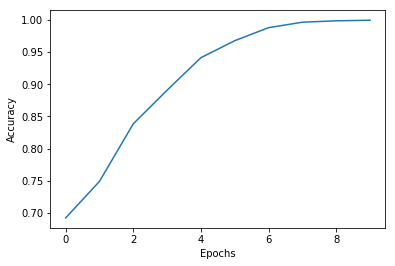

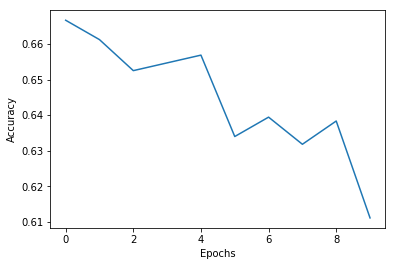

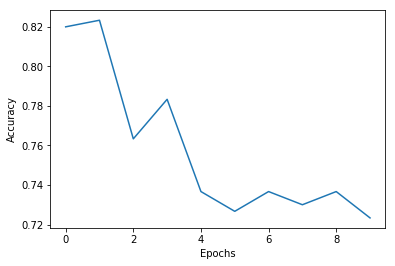

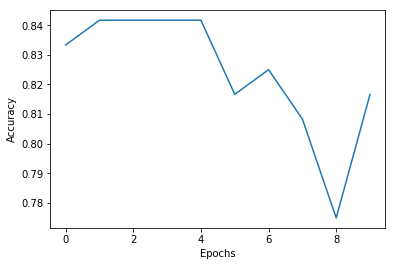

Epoch 1/1
20/20 [==============================] - 0s 8ms/step
Epoch 2/2
20/20 [==============================] - 0s 9ms/step
Epoch 3/3
20/20 [==============================] - 0s 8ms/step
Epoch 4/4
20/20 [==============================] - 0s 7ms/step
Epoch 5/5
20/20 [==============================] - 0s 9ms/step
Epoch 6/6
20/20 [==============================] - 0s 9ms/step
Epoch 7/7
20/20 [==============================] - 0s 8ms/step
Epoch 8/8
20/20 [==============================] - 0s 9ms/step
Epoch 9/9
20/20 [==============================] - 0s 10ms/step
Epoch 10/10
20/20 [==============================] - 0s 9ms/step
model = xception
top_layer_name = add_11
layers = 1
neurons_per_layer = 1000
tr_best_epoch = 9
tr_best_value = 1.0
te_1_best_epoch = 1
te_1_best_value = 0.6677559972588533
te_2_best_epoch = 1
te_2_best_value = 0.8099999713897705
te_3_best_epoch = 2
te_3_best_value = 0.8416666984558105


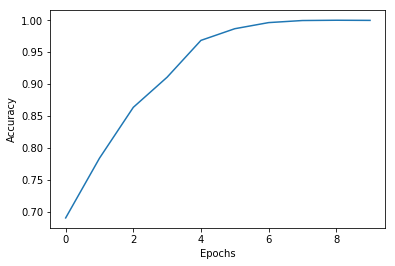

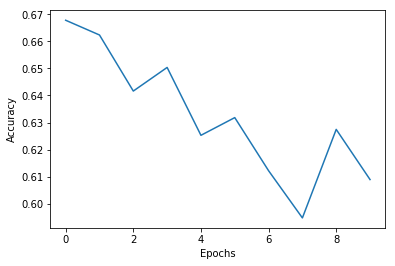

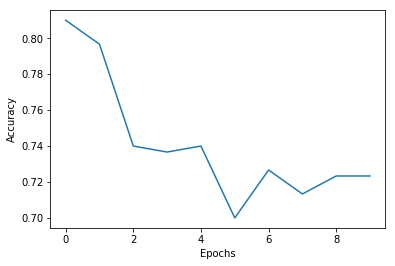

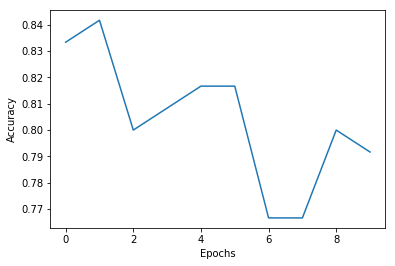

Epoch 1/1
20/20 [==============================] - 0s 18ms/step
Epoch 2/2
20/20 [==============================] - 0s 13ms/step
Epoch 3/3
20/20 [==============================] - 0s 13ms/step
Epoch 4/4
20/20 [==============================] - 0s 12ms/step
Epoch 5/5
20/20 [==============================] - 0s 14ms/step
Epoch 6/6
20/20 [==============================] - 0s 12ms/step
Epoch 7/7
20/20 [==============================] - 0s 16ms/step
Epoch 8/8
20/20 [==============================] - 0s 17ms/step
Epoch 9/9
20/20 [==============================] - 0s 10ms/step
Epoch 10/10
20/20 [==============================] - 0s 8ms/step
model = xception
top_layer_name = add_11
layers = 1
neurons_per_layer = 1500
tr_best_epoch = 8
tr_best_value = 1.0
te_1_best_epoch = 1
te_1_best_value = 0.6677560097251842
te_2_best_epoch = 1
te_2_best_value = 0.8199999713897705
te_3_best_epoch = 1
te_3_best_value = 0.8416666984558105


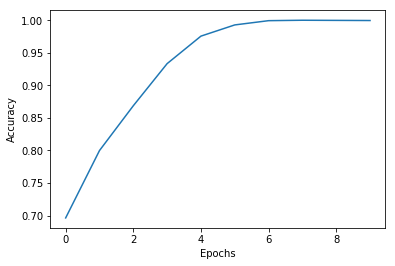

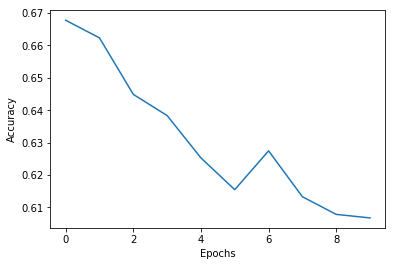

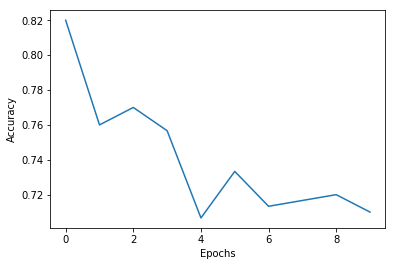

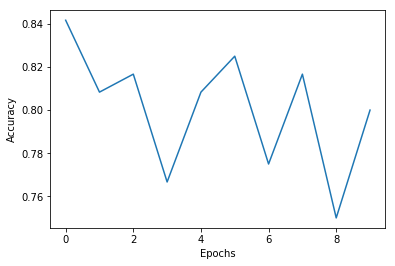

Epoch 1/1
576/765 [=====================>........] - ETA: 4s - loss: 0.6649 - acc: 0.6418

In [ ]:
test_all()

# TEST/DEBUG CELLS BELOW

In [ ]:
# Trying to find why, for certain transfer models and layers, my model doesn't change or learn anything.
# Update: Seems like both models below (one using relu and one using sigmoid) just learn the all-0's
# classifier.

transfer_model, transfer_input_size = get_transfer_model(MODELS[0])
X_tr, y_tr = get_X_y_from_folder(TRAIN_FOLDER, transfer_input_size)

popped_transfer_model = models.Model(inputs = transfer_model.inputs,
                                     outputs = transfer_model.layers[-(LAYERS_TO_POP[MODELS[0]][1] + 1)].output)

X_prime_tr = get_X_prime(popped_transfer_model, X_tr)

print(X_prime_tr.shape)
print(X_prime_tr)

In [ ]:
my_model = models.Sequential()
my_model.add(layers.Dense(units = 1000, activation = 'relu', input_dim = X_prime_tr.shape[1]))
my_model.add(layers.Dense(units = 1000, activation = 'relu'))
my_model.add(layers.Dense(units = 1000, activation = 'relu'))
my_model.add(layers.Dense(units = len(descriptor_corpus['idx_to_str']), activation = 'sigmoid'))
my_model.compile(loss = 'binary_crossentropy',
                 metrics=['accuracy'],
                 optimizer = 'Adam')

my_model.fit(X_prime_tr, y_tr,
             batch_size = BATCH_SIZE,
             epochs = 10)

print([[prediction, y_cur] for prediction, y_cur in zip(my_model.predict(X_prime_tr), y_tr)])

In [ ]:
my_model = models.Sequential()
my_model.add(layers.Dense(units = 1000, activation = 'sigmoid', input_dim = X_prime_tr.shape[1]))
my_model.add(layers.Dense(units = 1000, activation = 'sigmoid'))
my_model.add(layers.Dense(units = 1000, activation = 'sigmoid'))
my_model.add(layers.Dense(units = len(descriptor_corpus['idx_to_str']), activation = 'sigmoid'))
my_model.compile(loss = 'binary_crossentropy',
                 metrics=['accuracy'],
                 optimizer = 'Adam')

my_model.fit(X_prime_tr, y_tr,
             batch_size = BATCH_SIZE,
             epochs = 10)

print([[prediction, y_cur] for prediction, y_cur in zip(my_model.predict(X_prime_tr), y_tr)])